# Geometry #5
Visualize the combined influence of topography, water elevation level and bedrock elevation

## Initialization

In [1]:
# Import pyKasso and other useful packages
import pykasso as pk
import numpy as np
import pyvista as pv

In [2]:
# Create a pyKasso application
app = pk.pykasso()

# Declare the grid parameters
grid_parameters = {
    'x0' : 0,
    'y0' : 0,
    'z0' : 0,
    'nx' : 100,
    'ny' : 100,
    'nz' : 50,
    'dx' : 10,
    'dy' : 10,
    'dz' : 10
}

# Create a new project and declare its parameters
app.new_project(name='geometry_05', grid_parameters=grid_parameters)
app.visualizer.notebook = True
nx, ny, nz = app.project.grid.shape

In [3]:
# Declare the model parameters
model_parameters = {
    'sks' : {
        'seed' : 5555,
    },
    'domain' : {},
    'outlets' : {
        'number'     : 1,
        'data'       : [[994, 500]],
        'subdomain'  : 'domain_bottom',
    },
    'inlets' : {
        'number'     : 2,
        'data'       : [[0, 250], [0, 994]],
        'subdomain'  : 'domain_surface',
    },
}

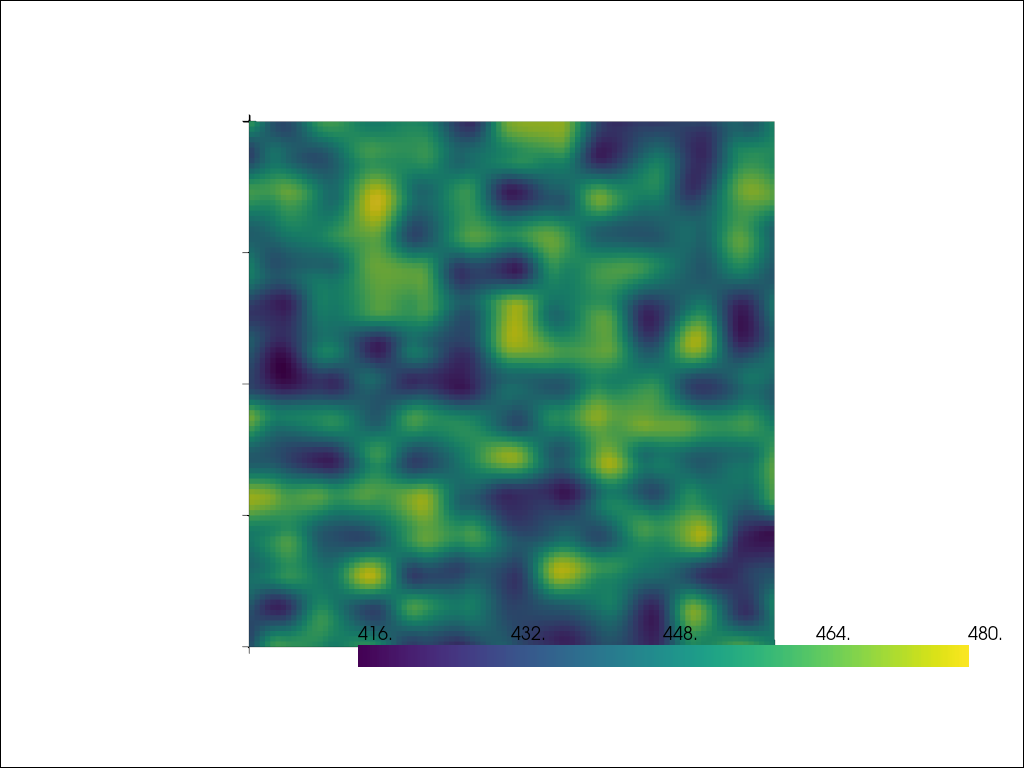

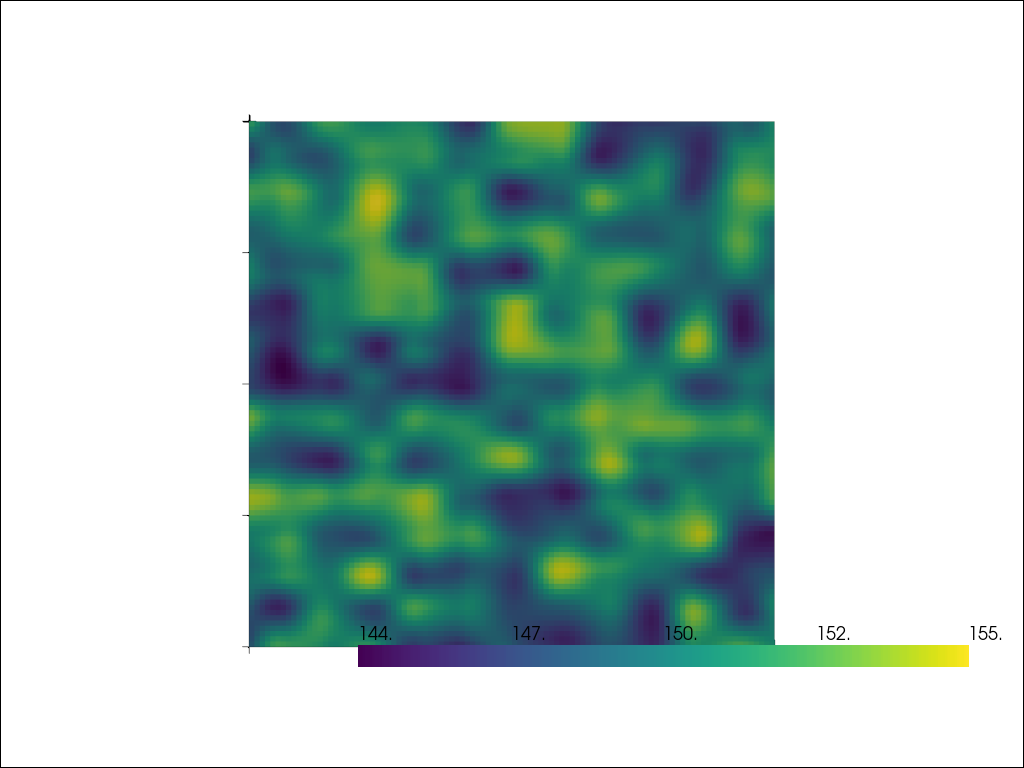

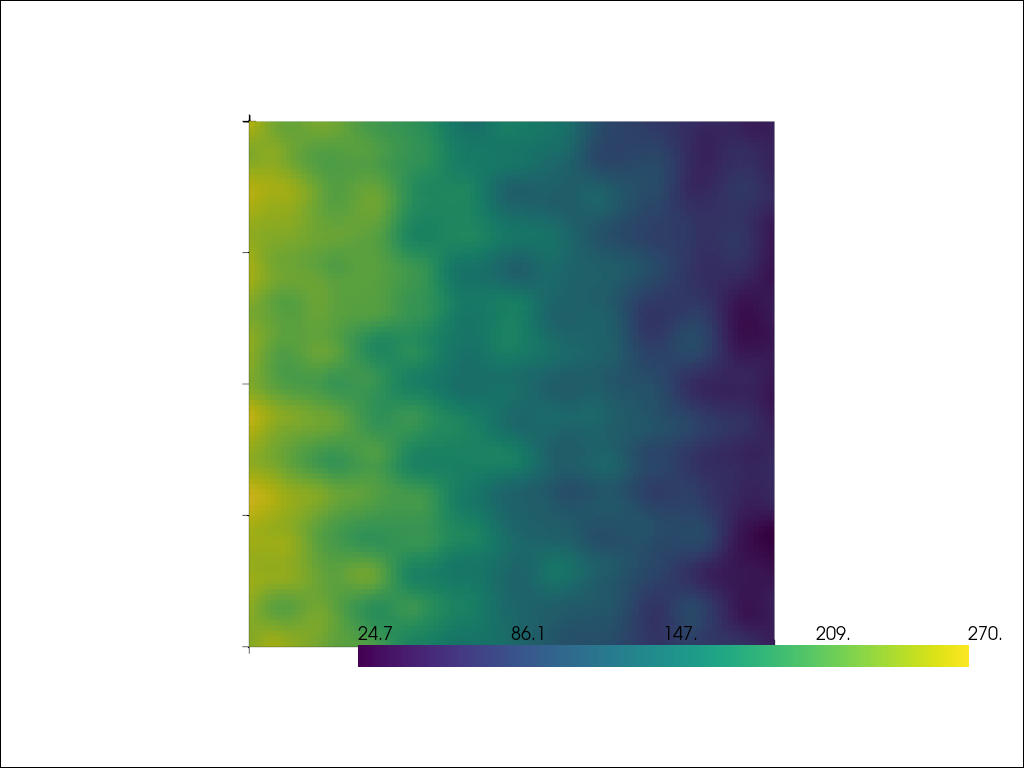

In [4]:
### With pyvista, generate 2D-perlin noise surfaces
freq = [0.689, 0.562, 0.683]
noise = pv.perlin_noise(1, freq, (0, 0, 0))

# topography
topography = pv.sample_function(noise, bounds=(-10, 10, -10, 10, -10, 10), dim=(nx, ny, 1))
topography = topography['scalars']
topography = topography.reshape((nx, ny))
topography = 30 * topography + 450
app.visualizer.pv_plot_array(topography)

# water tabel
water_table = pv.sample_function(noise, bounds=(-10, 10, -10, 10, -10, 10), dim=(nx, ny, 1))
water_table = water_table['scalars']
water_table = water_table.reshape((nx, ny))
water_table = 5 * water_table + 150
app.visualizer.pv_plot_array(water_table)

# bedrock
bedrock = pv.sample_function(noise, bounds=(-10, 10, -10, 10, -10, 10), dim=(nx, ny, 1))
bedrock = bedrock['scalars']
bedrock = bedrock.reshape((nx, ny))
plane = np.linspace(250, 50, nx)
plane = np.repeat(plane[:, np.newaxis], ny, axis=1)
bedrock = 25 * bedrock + plane
app.visualizer.pv_plot_array(bedrock)

# Update the parameters
model_parameters['domain']['topography']  = topography
model_parameters['domain']['water_table'] = water_table
model_parameters['domain']['bedrock']     = bedrock

In [5]:
# Compute karst conduit networks  
model_parameters['sks']['algorithm'] = 'Isotropic3'
app.model.generate(model_parameters)
    
model_parameters['sks']['algorithm'] = 'Riemann3'
model_parameters['sks']['costs'] = {'ratio': 0.1}
app.model.generate(model_parameters)

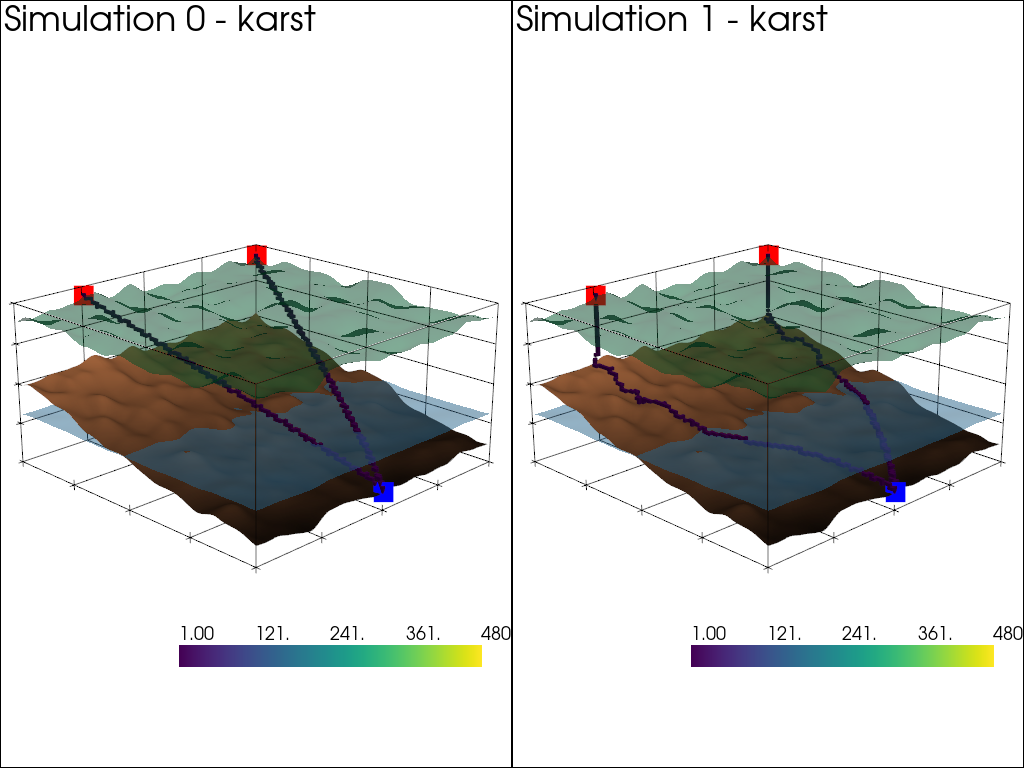

In [6]:
# Visualize the results
settings = {
    'mask_values': [0],
    'show_outline' : True,
    'inlets_options' : {},
    'outlets_options' : {},
    'surfaces_options' : {
        'topography' : {
            'opacity' : 0.5,
            'cmap': 'YlGn'
        },
        'bedrock' :  {
            'opacity' : 1,
            'cmap': 'copper'
        },
        'water_table' : {
            'opacity' : 0.5,
            'cmap': 'Blues_r'
        }
    },
}
last_simulations = app.project.get_last_simulations(2)
app.visualizer.pv_show(
    simulations=last_simulations,
    features=['karst'],
    settings=settings,
    cpos=[1, -1, 0.5],
)